In [1]:
import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
os.chdir("/nfs/homedirs/schwienb/project-4")

In [2]:
from src.data.mnist import MNISTDataModule, ConstantDataset, RandomDataset
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.pixelcnn import PixelCNN
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [4]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=3,
   verbose=True,
)
model_params = {
    'background_subtraction': False,
    'background_subtraction_value': 0.8,
    'bg_aug_max': 1.0
}
dataset_params = {
}
model = BgAugPixelCNN
dataset = FashionMNISTDataModule

# bgSub = .5
# bgSub00 = 0.0
# BG05 = bg_aug_max

EarlyStopping mode set to min for monitoring val_loss.


In [5]:
exp = Experiment('BgAugPixelCNN_BgSub08_2NORM_BGAUG10_FashionMNIST_1', 
                 model=model, dataset=dataset, model_params=model_params, dataset_params=dataset_params, callbacks=[early_stop_callback])
exp.setup_new()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [6]:
exp.train()

/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 1 M   


Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the Lightni

In [8]:
exp.save()

/nfs/homedirs/schwienb/project-4/src/utils/pixelcnn.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


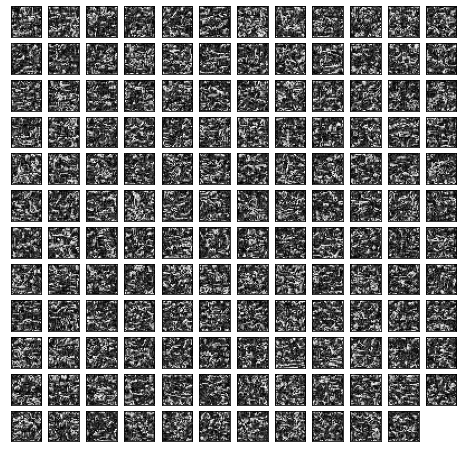

In [7]:
generate_images(exp.model)

In [61]:
mnist_exp_old = Experiment(PixelCNN, MNISTDataModule, "PixelCNN_MNIST_1.3", callbacks=[early_stop_callback])
mnist_exp_old.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
mnist_exp = Experiment(BgAugPixelCNN, BgAugMNISTDataModule, "BgAugPixelCNN_MNIST_1", callbacks=[early_stop_callback])
mnist_exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [14]:
data = mnist_exp.dataset.test_dataloader()

In [17]:
img = next(iter(data))
res = mnist_exp.model(img[0].cuda())

In [18]:
res.shape

torch.Size([1, 256, 28, 28])

In [33]:
img[0][0][0][7,6] * 255

tensor(84.)

In [41]:
mnist_exp.model.eval()
res = mnist_exp.model(img[0].cuda())

In [11]:
def likelihood(img_data, model):
    img = img_data[0]
    img = img.cuda()
    model.eval()
    res = model(img)
    like = torch.zeros((28,28))
    for i in range(28):
        for j in range(28):
            probs = F.softmax(res[0, :, 1, 1], dim=0)
            prob = (img[0, :, i, j] * 255.).int().cpu().numpy()[0]
            like[i][j] = probs[prob]
    return like

In [12]:
def draw_likelihood_plot(data, model):
    columns = 3
    rows = 3
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    i = 1
    for img in iter(data):
        if i <= 9:
            fig.add_subplot(rows, columns, i)
            like = likelihood(img, model)
            plt.imshow(like.detach().cpu().numpy(), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        i += 1
    plt.show()

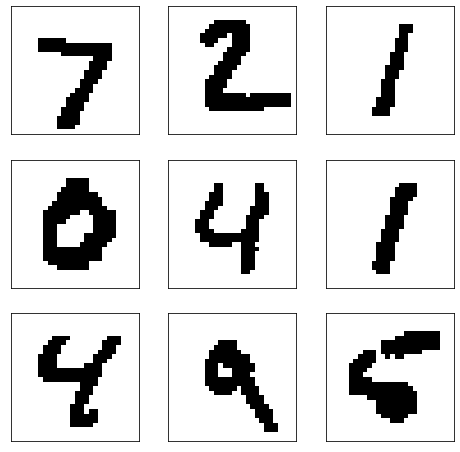

In [15]:
draw_likelihood_plot(data, mnist_exp.model)

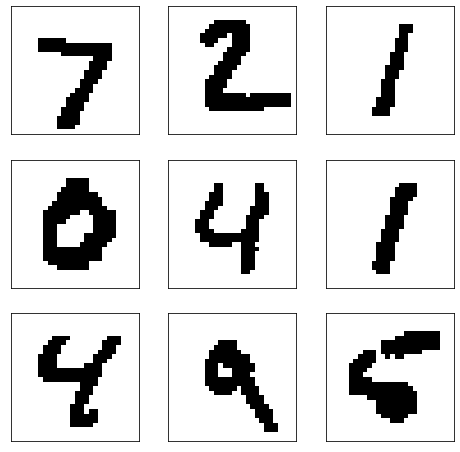

In [69]:
draw_likelihood_plot(data, mnist_exp_old.model)

In [14]:
mnist_exp = Experiment(BgAugPixelCNN, BgAugMNISTDataModule, "BgAugPixelCNN_1_DL_MNIST_1", callbacks=[early_stop_callback])
mnist_exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [27]:
mnist_testdataloader = mnist_exp.dataset.test_dataloader()
fashionmnist_testdataloader = fashionmnist_exp.dataset.test_dataloader()

In [28]:
mnist_test_fashion = fashionmnist_exp.trainer.test(fashionmnist_exp.model, test_dataloaders=[fashionmnist_testdataloader], verbose=False)

Set SLURM handle signals.


In [29]:
mnist_test_mnist = fashionmnist_exp.trainer.test(fashionmnist_exp.model, test_dataloaders=[mnist_testdataloader], verbose=False)

Set SLURM handle signals.


In [30]:
losses = torch.Tensor(mnist_test_mnist[1]['loss']).numpy()
fashionlosses = torch.Tensor(mnist_test_fashion[1]['loss']).numpy()

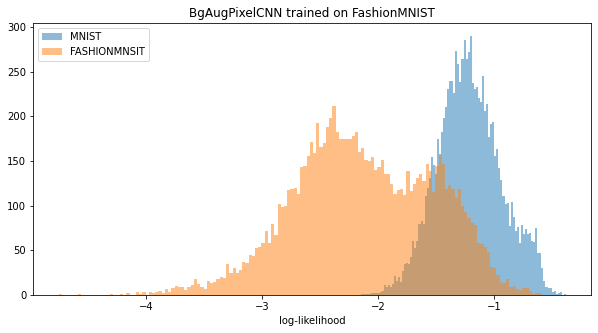

In [32]:
plt.figure(figsize=(10,5))
plt.hist(losses * -1, 100, alpha=0.5, label='MNIST')
plt.hist(fashionlosses * -1, 150, alpha=0.5, label='FASHIONMNSIT')
plt.legend(loc='upper left')
plt.xlabel('log-likelihood')
plt.title('BgAugPixelCNN trained on FashionMNIST')
plt.show()